## **Use TF-Agent to Train a RL on Acrobot**

# **Set Up**

In [1]:
!apt-get install xvfb
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install tf-agents-nightly
try:
  %%tensorflow_version 2.x
except:
  pass

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.3 [783 kB]
Fetched 783 kB in 1s (979 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 134983 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.3_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.3) ...
Setting up xvfb (2:1.19.6-1ubuntu4.3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 1.5MB 3.4MB/s 
  Created wheel for gym: filename=

In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common



tf.compat.v1.enable_v2_behavior()


# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
import tensorflow_probability as tfp
import numpy as np

from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.networks import network

from tf_agents.policies import py_policy
from tf_agents.policies import random_py_policy
from tf_agents.policies import scripted_py_policy

from tf_agents.policies import tf_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import actor_policy
from tf_agents.policies import q_policy
from tf_agents.policies import greedy_policy

from tf_agents.trajectories import time_step as ts

In [0]:
num_iterations = 200000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 500  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

# **Environment**

Acrobot is a 2-link pendulum with only the second joint actuated. Initially, both links point downwards. The goal is to swing the end-effector at a height at least the length of one link above the base. Both links can swing freely and can pass by each other, i.e., they don't collide when they have the same angle.

The obersvations consists of the sin() and cos() of the two rotational joint angles and the joint angular velocities : [cos(theta1) sin(theta1) cos(theta2) sin(theta2) thetaDot1 thetaDot2].

The reward is -1 as long as the end-effector does not reach a certain height.

In [0]:
env_name = 'Alien-ram-v0'
env = suite_gym.load(env_name)

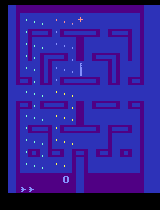

In [6]:
env.reset()
PIL.Image.fromarray(env.render())

In [7]:
print('Observation Spec:', env.time_step_spec().observation)
print('Reward Spec:', env.time_step_spec().reward)
print('Action Spec:', env.action_spec())

Observation Spec: BoundedArraySpec(shape=(128,), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)
Reward Spec: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec: BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=17)


Try

In [8]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = 2

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

num = 0
while not next_time_step.is_last():
  next_time_step = env.step(action)
  num = num + 1

# stop after 500 steps
print(num)
print(next_time_step)

Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([  1,   0,  71, 128,   0, 128, 240, 128, 240, 128, 240, 128, 240,
         0, 240, 255,   0, 136, 240,  26, 241,   1,   2,   6,   5,   3,
         6,   0,   1,   6, 255,   0,   0,   0,   3,  87,  87,  87, 139,
       135,   0,   0,   0,   0,   0,  67,  90,   0,   0,   0,   0,   0,
        60,  59,  60, 112, 112, 112, 116, 147, 116,   0,  11,   0,   3,
       255,  14, 255, 148, 190,  24, 255, 144, 255,  12, 255,  68, 127,
       255, 192, 255, 164, 244,  96, 255,  36, 255, 192, 255, 136, 248,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4,   3,
         0,   0,  25,   0,   0,   0,   0,   0,  11,   0,   0,   0, 255,
       190,  30,  94, 142,  78,  30, 142,  96, 132, 254, 248], dtype=uint8))
Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=arra

Instantiate two environment

In [0]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# **Agent**-DQN

In [0]:
#NN Q Function
fc_layer_params = (100,100)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [0]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    n_step_update=2)

agent.initialize()

# **Policies**

In [0]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                          train_env.action_spec())

# **Metrix and Evaluation**

In [0]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [14]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

140.0

# **Replay Buffer**

In [15]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

agent.collect_data_spec
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

# **Data Collecting Function**

In [0]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

In [0]:
collect_step(train_env, agent.collect_policy, replay_buffer)

In [23]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=3).prefetch(3)

iterator = iter(dataset)

print(iterator)

In [28]:
experience, unused_info = next(iterator)
#agent.train(experience, weights=[1,1])
experience

Trajectory(step_type=<tf.Tensor: id=610075, shape=(64, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
   

# **Train**

In [0]:
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)
  
  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss
  
  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 500: loss = 4263675166720.0
step = 1000: loss = 29908669562880.0
step = 1000: Average Return = 0.0
step = 1500: loss = 102974969872384.0
step = 2000: loss = 590187495161856.0
step = 2000: Average Return = 30.0
step = 2500: loss = 535131651571712.0
step = 3000: loss = 2098612557316096.0
step = 3000: Average Return = 30.0
step = 3500: loss = 2772981210152960.0
step = 4000: loss = 3310303093719040.0
step = 4000: Average Return = 0.0
step = 4500: loss = 3882387905708032.0
step = 5000: loss = 1.665314470274007e+17
step = 5000: Average Return = 30.0
step = 5500: loss = 1.0982828376326144e+16
step = 6000: loss = 8684267643076608.0
step = 6000: Average Return = 30.0
step = 6500: loss = 1.1986441974317056e+16
step = 7000: loss = 1.0618209275215872e+16
step = 7000: Average Return = 0.0
step = 7500: loss = 1.7270147249078272e+16
step = 8000: loss = 2.0052895214862336e+16
step = 8000: Average Return = 0.0
step = 8500: loss = 1.9439855205351424e+16
step = 9000: loss = 2.475212416011469e+16
s

# **Visualization**

In [0]:
## Plot

iterations = range(0, num_iterations + 1, eval_interval)
plt.figure(figsize=(20,5))
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [0]:
## Video
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

In [0]:
action_spec = array_spec.BoundedArraySpec((), np.int64, 0, 0)
my_random_py_policy = random_py_policy.RandomPyPolicy(time_step_spec=None,
    action_spec=action_spec)

In [0]:
create_policy_eval_video(my_random_py_policy, "doomy-agent")

explore maually

In [0]:
collect_data(train_env, random_policy, replay_buffer, steps=100)

In [0]:
iter(replay_buffer.as_dataset()).next()